<a href="https://colab.research.google.com/github/hilaler/AutoML/blob/main/AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install niapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 31.8 MB/s 


## Import Needed Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from scipy import stats
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from niapy.problems import Problem
from niapy.task import OptimizationType, Task
from niapy.algorithms.modified import HybridBatAlgorithm
from niapy.algorithms.basic import ParticleSwarmOptimization
from sklearn.svm import SVR

## Read Data

In [3]:
df_train = pd.read_excel('https://github.com/hilaler/AutoML/blob/main/boston_train.xlsx?raw=true')
df_test = pd.read_excel('https://github.com/hilaler/AutoML/blob/main/boston_test.xlsx?raw=true')

# Detail
crim : per capita crime rate by town.

zn : proportion of residential land zoned for lots over 25,000 sq.ft.

indus : proportion of non-retail business acres per town.

chas : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

nox : nitrogen oxides concentration (parts per 10 million).

rm : average number of rooms per dwelling.

age : proportion of owner-occupied units built prior to 1940.

dis : weighted mean of distances to five Boston employment centres.

rad : index of accessibility to radial highways.

tax : full-value property-tax rate per \$10,000.

ptratio : pupil-teacher ratio by town.

black : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

lstat : lower status of the population (percent).

medv : median value of owner-occupied homes in \$1000s.

## Remove Null Values and Duplicate Data

In [4]:
print(df_train.isnull().sum())
print(df_train[df_train.duplicated()])

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64
Empty DataFrame
Columns: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT, PRICE]
Index: []


In [5]:
print(df_test.isnull().sum())
print(df_test[df_train.duplicated()])

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64
Empty DataFrame
Columns: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT, PRICE]
Index: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Outliers

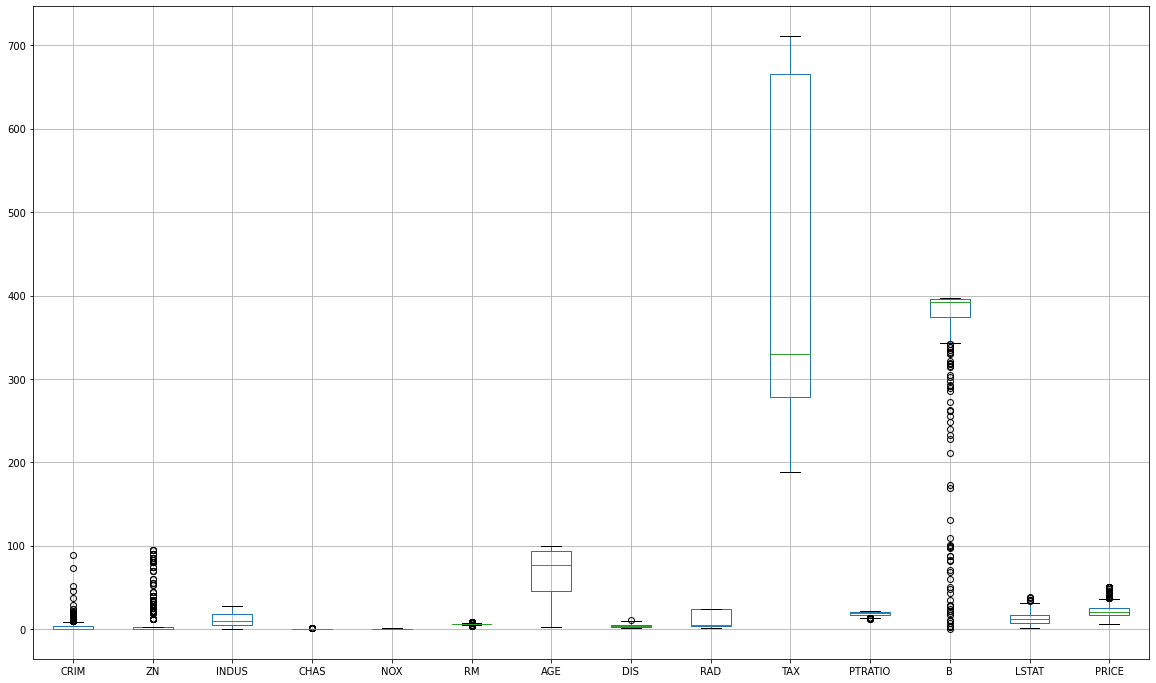

In [6]:
df_train[df_train.columns].boxplot(figsize=(20,12))

In [7]:
def quartile(df_,x):
  q1 = (df_[x]).quantile(0.25)
  q3 = (df_[x]).quantile(0.75) 
  iqr = q3 - q1
  max = q3 + (1.5 *iqr)
  min = q1 - (1.5 *iqr)
  return max,min

def sub_outliers(df_,x,max,min):
  df_[x] = df_[x].mask(df_[x] > max, max,axis=0)
  df_[x] = df_[x].mask(df_[x] < min, min,axis=0)
  return df_

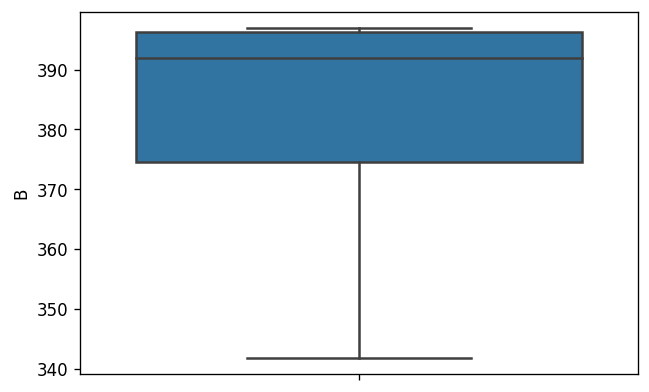

In [8]:
max,min = quartile(df_train,'B')
df_train = sub_outliers(df_train,'B',max,min)
mp.rcParams['figure.dpi'] = 120

sns.boxplot(y=df_train["B"])
plt.subplots_adjust(wspace=10)

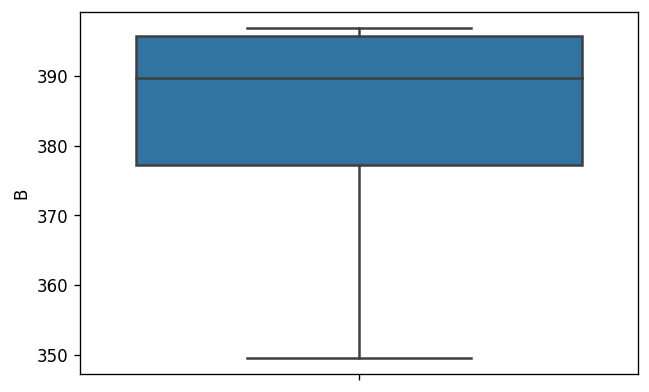

In [9]:
max,min = quartile(df_test,'B')
df_test = sub_outliers(df_test,'B',max,min)
mp.rcParams['figure.dpi'] = 120

sns.boxplot(y=df_test["B"])
plt.subplots_adjust(wspace=10)

## Heatmap

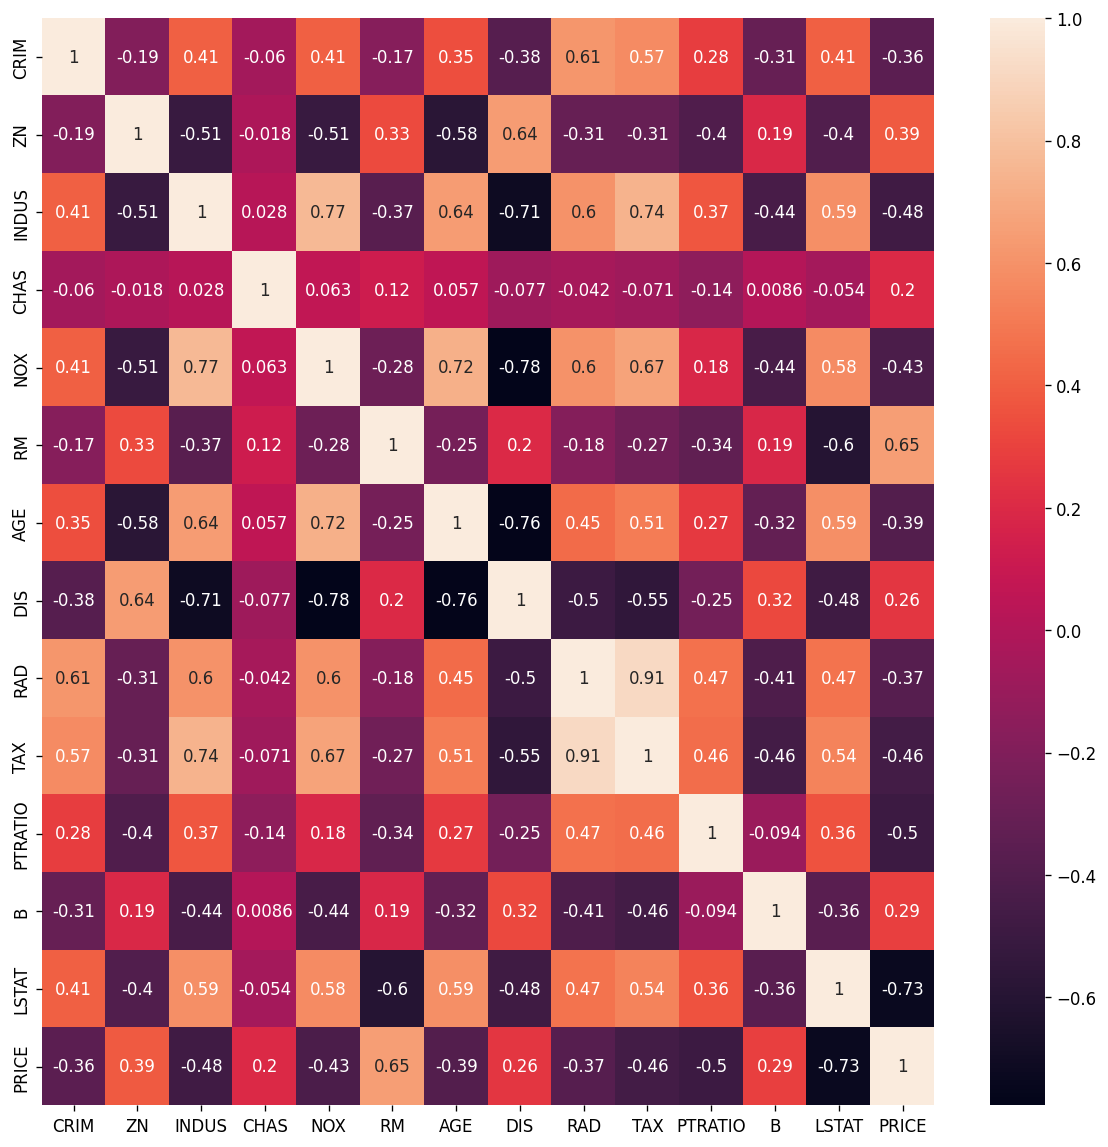

In [10]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [11]:
df_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.40771,0.0,6.20,1,0.5070,6.164,91.3,3.0480,8,307,17.4,395.24000,21.46,21.7
1,19.60910,0.0,18.10,0,0.6710,7.313,97.9,1.3163,24,666,20.2,396.90000,13.44,15.0
2,6.71772,0.0,18.10,0,0.7130,6.749,92.6,2.3236,24,666,20.2,341.89125,17.44,13.4
3,1.51902,0.0,19.58,1,0.6050,8.375,93.9,2.1620,5,403,14.7,388.45000,3.32,50.0
4,9.59571,0.0,18.10,0,0.6930,6.404,100.0,1.6390,24,666,20.2,376.11000,20.31,12.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55000,2.88,50.0
400,0.04981,21.0,5.64,0,0.4390,5.998,21.4,6.8147,4,243,16.8,396.90000,8.43,23.4
401,0.08199,0.0,13.92,0,0.4370,6.009,42.3,5.5027,4,289,16.0,396.90000,10.40,21.7
402,0.37578,0.0,10.59,1,0.4890,5.404,88.6,3.6650,4,277,18.6,395.24000,23.98,19.3


## Normalization

In [12]:
scalling = MinMaxScaler().fit(df_train[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']])
df_train[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']]=scalling.transform(df_train[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']])
df_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.004512,0.000000,0.210411,1.0,0.251029,0.498755,0.910402,0.202874,0.304348,0.227533,0.510638,0.969823,0.544426,0.352403
1,0.220331,0.000000,0.646628,0.0,0.588477,0.718912,0.978373,0.019744,1.000000,0.913958,0.808511,1.000000,0.323124,0.199085
2,0.075435,0.000000,0.646628,0.0,0.674897,0.610845,0.923790,0.126268,1.000000,0.913958,0.808511,0.000000,0.433499,0.162471
3,0.017002,0.000000,0.700880,1.0,0.452675,0.922399,0.937178,0.109178,0.173913,0.411090,0.223404,0.846388,0.043874,1.000000
4,0.107782,0.000000,0.646628,0.0,0.633745,0.544740,1.000000,0.053870,1.000000,0.913958,0.808511,0.622060,0.512693,0.132723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.000155,1.000000,0.081378,0.0,0.063992,0.857061,0.298661,0.421781,0.130435,0.068834,0.223404,0.884564,0.031733,1.000000
400,0.000489,0.221053,0.189883,0.0,0.111111,0.466948,0.190525,0.601210,0.130435,0.105163,0.446809,1.000000,0.184879,0.391304
401,0.000851,0.000000,0.493402,0.0,0.106996,0.469055,0.405767,0.462463,0.130435,0.193117,0.361702,1.000000,0.239238,0.352403
402,0.004153,0.000000,0.371334,1.0,0.213992,0.353133,0.882595,0.268123,0.130435,0.170172,0.638298,0.969823,0.613962,0.297483


In [13]:
scalling = MinMaxScaler().fit(df_test[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']])
df_test[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']]=scalling.transform(df_test[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']])
df_test

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.000126,0.175,0.004908,0.0,0.056224,0.646610,0.569149,0.734792,0.086957,0.055344,0.622222,0.922685,0.202266,0.622222
1,0.002028,0.000,0.275953,0.0,0.271784,0.564421,0.786170,0.146113,0.173913,0.375954,0.877778,0.954794,0.247917,0.500000
2,0.368653,0.000,0.636089,0.0,0.630705,0.403096,1.000000,0.037512,1.000000,0.914122,0.800000,1.000000,0.826058,0.013333
3,0.053935,0.000,0.636089,0.0,0.402490,0.473948,0.488298,0.256987,1.000000,0.914122,0.800000,0.825090,0.286571,0.360000
4,0.139931,0.000,0.636089,0.0,0.672199,0.564639,0.937234,0.120383,1.000000,0.914122,0.800000,0.000000,0.557481,0.220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.000753,0.400,0.000000,0.0,0.082988,0.512753,0.408511,0.695444,0.000000,0.282443,0.744444,1.000000,0.133289,0.397778
98,0.000856,0.450,0.082673,0.0,0.099585,0.567037,0.263830,0.484244,0.173913,0.402672,0.244444,0.848116,0.090303,0.566667
99,0.001201,0.300,0.138920,0.0,0.080913,0.538042,0.385106,0.457766,0.217391,0.215649,0.400000,0.722849,0.179607,0.406667
100,0.003721,0.000,0.275953,0.0,0.271784,0.455853,0.906383,0.124858,0.173913,0.375954,0.877778,0.880225,0.452183,0.320000


## Data Splitting

In [14]:
X_train = df_train.drop(columns=['PRICE'], axis= 1)
y_train = df_train['PRICE']
X_test = df_test.drop(columns=['PRICE'], axis= 1)
y_test = df_test['PRICE']

## Optimization

In [15]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [16]:
class SVMHyperparameterOptimization(Problem):
    def __init__(self, lower, upper, X_train, y_train, X_test, y_test):
        super().__init__(dimension=3, lower=lower, upper=upper)
        self.X_tr, self.y_tr, self.X_val, self.y_val = X_train, y_train, X_test, y_test

    def _evaluate(self, x):
        model = SVR(C=x[0], epsilon=x[1], gamma=x[2])
        model.fit(self.X_tr, self.y_tr)
        result = model.predict(self.X_val)
        mape = MAPE(self.y_val, result)
        return mape

In [17]:
lower = (0.01, 0.0001, 0.0001)
upper = (32000.0, 32.0, 1.0)

problem = SVMHyperparameterOptimization(lower, upper, X_train, y_train, X_test, y_test)

task = Task(problem=problem, max_iters=100)

pso = ParticleSwarmOptimization(population_size=10, c1=2.0, c2=2.0)

best_params, best_mape = pso.run(task)
C, gamma, epsilon = best_params
print('Best parameters: C={}; gamma={}; epsilon={}'.format(C, gamma, epsilon))
print('Best score:', best_mape)

Best parameters: C=12980.677573572471; gamma=23.606532836664165; epsilon=0.7223409868623719
Best score: inf


In [18]:
svr = SVR(C=3210.438995389343, gamma=25.5926786115159, epsilon=0.4335846108159131)

In [19]:
svr.get_params()

{'C': 3210.438995389343,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.4335846108159131,
 'gamma': 25.5926786115159,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [20]:
svr.fit(X_train,y_train)

SVR(C=3210.438995389343, epsilon=0.4335846108159131, gamma=25.5926786115159)

In [21]:
tr_pred = svr.predict(X_train)
tr_pred

array([0.52267656, 0.51358477, 0.51128543, 0.56642685, 0.5221712 ,
       0.48070528, 0.52276661, 0.52267766, 0.47909096, 0.52271292,
       0.52196306, 0.52267734, 0.52267656, 0.5226793 , 0.52270625,
       0.52268013, 0.52267656, 0.52624394, 0.52267674, 0.52210468,
       0.52267659, 0.52270753, 0.52267658, 0.52267656, 0.52267699,
       0.52267716, 0.52267656, 0.5226909 , 0.52267656, 0.52267685,
       0.52196781, 0.48845971, 0.52229515, 0.48895116, 0.52267656,
       0.52287839, 0.51113899, 0.52549404, 0.52267656, 0.50409325,
       0.52279354, 0.52267656, 0.52297342, 0.52267656, 0.5242656 ,
       0.5226852 , 0.52268331, 0.49076995, 0.52267657, 0.52271148,
       0.53214835, 0.52267656, 0.4613823 , 0.52369712, 0.5226789 ,
       0.5226779 , 0.5222862 , 0.52267656, 0.52267656, 0.52409709,
       0.52267656, 0.50523625, 0.52235369, 0.5226854 , 0.52267706,
       0.52273322, 0.52272914, 0.52267882, 0.52268028, 0.52267664,
       0.52267664, 0.50630324, 0.52270856, 0.52223599, 0.49052

In [22]:
score_1 = metrics.r2_score(y_train, tr_pred)

score_2 = metrics.mean_absolute_error(y_train, tr_pred)

print("R squared error : ", score_1)
print('Mean Absolute Error : ', score_2)

R squared error :  -0.4396088175263897
Mean Absolute Error :  0.21610600245272937


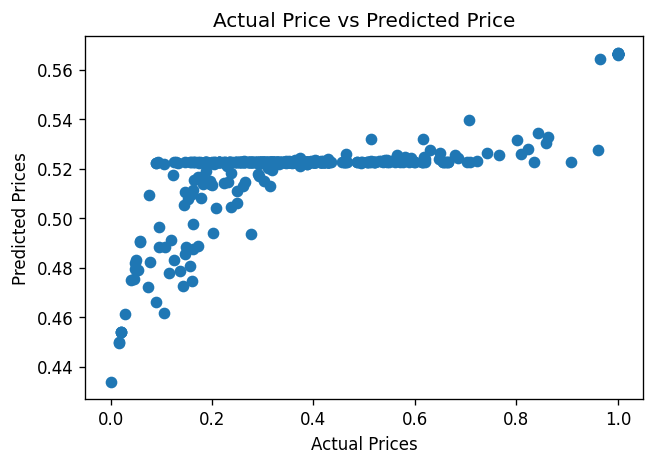

In [23]:
plt.scatter(y_train, tr_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Price vs Predicted Price")
plt.show()

In [24]:
test_pred = svr.predict(X_test)

In [25]:
score_1 = metrics.r2_score(y_test, test_pred)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(y_test, test_pred)

print("R squared error : ", score_1)
print('Mean Absolute Error : ', score_2)


R squared error :  -0.23940153322364321
Mean Absolute Error :  0.2148270832498734


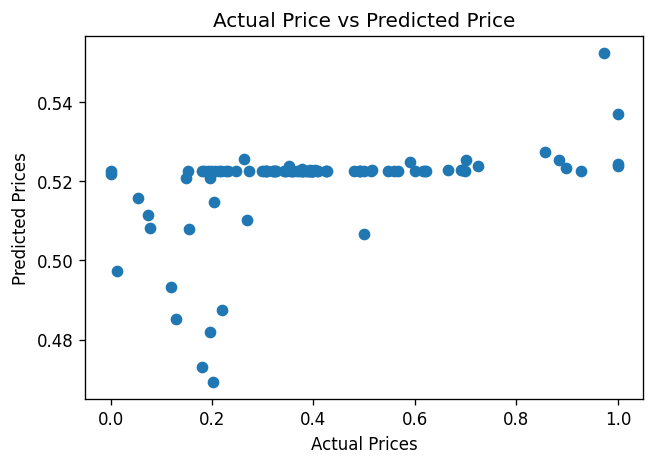

In [26]:
plt.scatter(y_test, test_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Price vs Predicted Price")
plt.show()